In [3]:
import os

In [4]:
%pwd

'c:\\Users\\Lenovo\\Desktop\\stb_pfe_mlflow\\research'

In [5]:
os.chdir("../")

In [6]:
%pwd

'c:\\Users\\Lenovo\\Desktop\\stb_pfe_mlflow'

In [7]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [8]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class DataCleaningConfig:
    root_dir: Path
    data_path: Path

In [9]:
from stb_pfe_mlflow.constants import *
from stb_pfe_mlflow.utils.common import read_yaml, create_directories

In [10]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])
   
    def get_data_cleaning_config(self) -> DataCleaningConfig:
        config = self.config.data_cleaning

        create_directories([config.root_dir])

        data_cleaning_config = DataCleaningConfig(
            root_dir=config.root_dir,
            data_path=config.data_path,
        )

        return data_cleaning_config

    
   

In [11]:
import os
import urllib.request as request

from stb_pfe_mlflow import logger
from stb_pfe_mlflow.utils.common import get_size

In [12]:
df= pd.read_csv("artifacts/data_ingestion/data.csv")
df.head()

,tiers_key,ca,TOTMVTC,TOTMVTD,TOTMVTCnet,TOTMVTDnet,ENG,MontImp,encours,Encours_Moyen_Debiteur,...,Code_Classe,Var Signalitiques.Code_Profession,Var Signalitiques.Profession,Var Signalitiques.Code_Activite_Economique,Var Signalitiques.Activite_Economique,Var Signalitiques.Code_secteur_activite,Var Signalitiques.Secteur_Activite,Var Signalitiques.Ville,Var Signalitiques.Code_Postal,Var Signalitiques.Date_Ouverture
0,174,NaN,0.000,-274.956,0.000,-261.171,NaN,NaN,NaN,1420.500876,...,1.0,NaN,NaN,HAB99,TRANSPORTS FERROVIAIRES DE FRET,HA,TRANSPORTS ET ENTREPOSAGE,BAB BHAR,1000.0,1958-04-05
1,370,NaN,0.000,-483.776,0.000,-450.691,NaN,NaN,NaN,2311.483331,...,1.0,NaN,NaN,GCG99,AUTRES COMMERCES DE DETAIL DE BIENS NEUFS EN M...,NaN,NaN,TUNIS,1002.0,1992-04-14
2,481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,DAA04,COMMERCE D'ELECTRICITE,DA,"PRODUCTION ET DISTRIBUTION D'ELECTRICITE, DE G...",TUNIS BELVEDERE,1002.0,2000-01-01
3,578,NaN,0.000,-362.465,0.000,-341.152,NaN,NaN,NaN,1500.732704,...,NaN,NaN,NaN,CWA01,FABRICATION DE MEUBLES DE BUREAU ET DE MAGASIN,CW,INDUSTRIE MANUFACTURIERE,TUNIS BELVEDERE,1002.0,1992-05-07
4,633,3171.408,3224.323,-7610.750,3224.323,-7610.750,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,GBG05,COMMERCE DE GROS DE QUINCAILLERIE ET FOURNITUR...,GB,COMMERCE; REPARATION D'AUTOMOBILES ET DE MOTOC...,REPUBLIQUE,1001.0,1992-02-20


In [13]:
class DataCleaning:
    def __init__(self, config: DataCleaningConfig):
        self.config = config

    
    ## Note: You can add different data transformation techniques such as Scaler, PCA and all
    #You can perform all kinds of EDA in ML cycle here before passing this data to the model

    # I am only adding train_test_spliting cz this data is already cleaned up


    
    def cleaning_data(self):
        # Renommer les colonnes qui commencent par "Var Signalitiques."
        df.rename(columns=lambda x: x.replace("Var Signalitiques.", "") if x.startswith("Var Signalitiques.") else x, inplace=True)
    
        # Suppression des colonnes spécifiées
        columns_to_drop = [
        'INCIDENTCHQ_R', 'INCIDENTCHQ_N_R', 'INCIDENTCHQ', 'NBIMP',
        'Interdit', 'InterditAct', 'Interet_Non_ECHU', 'Encaiss_Recu', 'Code_Postal'
        ]
        df.drop(columns=columns_to_drop, inplace=True)

        # Remplir les valeurs manquantes dans les colonnes numériques avec la médiane ou la moyenne
        df['ca'].fillna(df['ca'].median(), inplace=True)
        df['TOTMVTC'].fillna(df['TOTMVTC'].mean(), inplace=True)
        df['TOTMVTD'].fillna(df['TOTMVTD'].mean(), inplace=True)
        df['TOTMVTCnet'].fillna(df['TOTMVTCnet'].mean(), inplace=True)
        df['TOTMVTDnet'].fillna(df['TOTMVTDnet'].mean(), inplace=True)
    
        # Assurer que TOTMVTC et TOTMVTCnet soient toujours positifs
        df['TOTMVTC'] = df['TOTMVTC'].abs()  # Convertir en valeur absolue pour s'assurer qu'il est positif
        df['TOTMVTCnet'] = df['TOTMVTCnet'].abs()  # Convertir en valeur absolue pour s'assurer qu'il est positif
    
        # Assurer que TOTMVTD et TOTMVTDnet soient toujours négatifs
        df['TOTMVTD'] = -df['TOTMVTD'].abs()  # Convertir en valeur absolue et rendre négatif
        df['TOTMVTDnet'] = -df['TOTMVTDnet'].abs()  # Convertir en valeur absolue et rendre négatif
    
        # Limiter le nombre de décimales à 2 pour une meilleure lisibilité
        df['TOTMVTC'] = df['TOTMVTC'].round(2)
        df['TOTMVTCnet'] = df['TOTMVTCnet'].round(2)
        df['TOTMVTD'] = df['TOTMVTD'].round(2)
        df['TOTMVTDnet'] = df['TOTMVTDnet'].round(2)
    
        # Remplir les valeurs manquantes dans 'ENG' par 0 (ou "Non")
        df['ENG'].fillna(0, inplace=True)  # Ici, on suppose que "0" représente une catégorie manquante
    
        # Remplir les valeurs manquantes dans 'MontImp' par 0
        df['MontImp'].fillna(0, inplace=True)
    
        # Conversion de la colonne 'encours' en numérique (et gestion des erreurs de conversion)
        df['encours'] = pd.to_numeric(df['encours'], errors='coerce')
    
        # Vérification du nombre de valeurs NaN dans 'encours'
        print(df['encours'].isna().sum())
    
        # Remplir les valeurs manquantes dans 'encours' avec la médiane
        df['encours'].fillna(df['encours'].median(), inplace=True)
    
        # Remplir les valeurs manquantes dans d'autres colonnes numériques avec la médiane
        df['Encours_Moyen_Debiteur'].fillna(df['Encours_Moyen_Debiteur'].median(), inplace=True)
        df['Encours_Moyen_crediteur'].fillna(df['Encours_Moyen_crediteur'].median(), inplace=True)
    
        # Remplir les valeurs manquantes dans 'NBECHEANCE' avec la moyenne
        df['NBECHEANCE'].fillna(df['NBECHEANCE'].mean(), inplace=True)
    
        # Remplir les valeurs manquantes dans 'Code_Classe' avec la valeur la plus fréquente (mode)
        df['Code_Classe'].fillna(df['Code_Classe'].mode()[0], inplace=True)

        # Remplir les valeurs manquantes dans certaines colonnes catégorielles avec la valeur la plus fréquente
        categorical_columns = ['Profession', 'Code_Profession', 'Secteur_Activite', 'Code_secteur_activite', 
                           'Activite_Economique', 'Code_Activite_Economique', 'Ville']
    
        for col in categorical_columns:
            if col in df.columns:  # Vérifie si la colonne existe dans le DataFrame
                df[col].fillna(df[col].mode()[0], inplace=True)
            else:
                print(f"Colonne '{col}' non trouvée dans le DataFrame.")

        # Assurez-vous que la colonne 'Date_Ouverture' est au format datetime
        df['Date_Ouverture'] = pd.to_datetime(df['Date_Ouverture'], errors='coerce')
    
        # Imputation des valeurs manquantes dans 'Date_Ouverture' avec la date médiane
        median_date = df['Date_Ouverture'].median()
        df['Date_Ouverture'].fillna(median_date, inplace=True)
    
        # Fonction pour calculer le nombre d'années écoulées depuis la date d'ouverture
        def calculate_years_since(date):
            today = pd.Timestamp.today()
            return today.year - date.year - ((today.month, today.day) < (date.month, date.day))
    
        # Appliquer la fonction pour créer une nouvelle colonne 'ancienneté' (en années)
        df['ancienneté'] = df['Date_Ouverture'].apply(calculate_years_since)
    
        # Afficher les premières lignes pour vérifier la transformation
        # print(df[['Date_Ouverture', 'ancienneté', 'TOTMVTC', 'TOTMVTD', 'TOTMVTCnet', 'TOTMVTDnet']].head())
    
        df.to_csv(os.path.join(self.config.root_dir, "clean_data.csv"),index = False)
        logger.info("Cleaning the data")
        logger.info(df.shape)
        
   

        

In [14]:
try:
    config = ConfigurationManager()
    data_cleaning_config = config.get_data_cleaning_config()
    data_cleaning = DataCleaning(config=data_cleaning_config)
    data_cleaning.cleaning_data()
except Exception as e:
    raise e

[2024-10-14 19:06:54,839: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-10-14 19:06:54,841: INFO: common: yaml file: params.yaml loaded successfully]
[2024-10-14 19:06:54,846: INFO: common: yaml file: schema.yaml loaded successfully]
[2024-10-14 19:06:54,848: INFO: common: created directory at: artifacts]
[2024-10-14 19:06:54,849: INFO: common: created directory at: artifacts/data_cleaning]
11457
[2024-10-14 19:06:55,068: INFO: 3365399240: Cleaning the data]
[2024-10-14 19:06:55,068: INFO: 3365399240: (12946, 22)]


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

                         Type de données  Valeurs manquantes  \
tiers_key                          int64                   0   
ca                               float64                   0   
Date_Ouverture            datetime64[ns]                   0   
Ville                             object                   0   
Secteur_Activite                  object                   0   
Code_secteur_activite             object                   0   
Activite_Economique               object                   0   
Code_Activite_Economique          object                   0   
Profession                        object                   0   
Code_Profession                   object                   0   
Code_Classe                      float64                   0   
NBECHEANCE                       float64                   0   
Encours_Moyen_crediteur          float64                   0   
Encours_Moyen_Debiteur           float64                   0   
encours                          float64

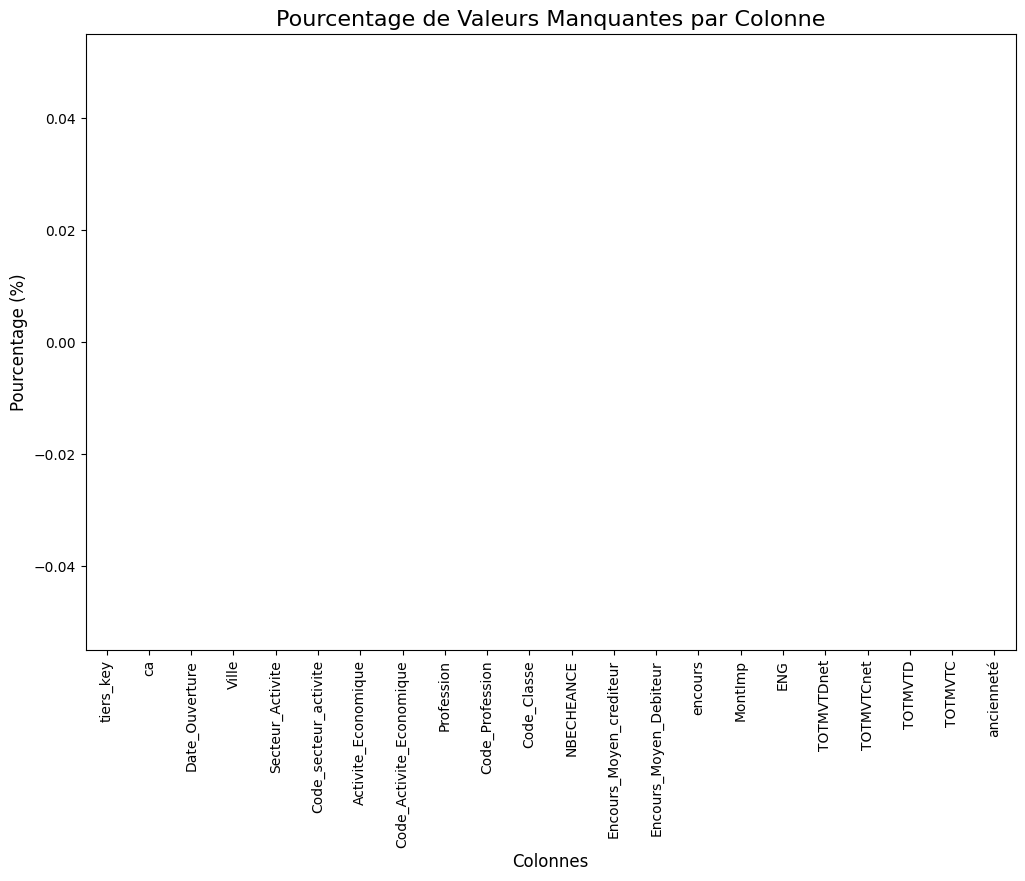

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Supposons que 'df' est votre DataFrame chargé
# df = pd.read_csv('votre_fichier.csv')  # Charger votre fichier

# Calculer le nombre de valeurs manquantes
missing_values = df.isnull().sum()

# Calculer le pourcentage de valeurs manquantes
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Récupérer les types de données
data_types = df.dtypes

# Créer un DataFrame résumant les résultats
missing_data_df = pd.DataFrame({
    'Type de données': data_types,
    'Valeurs manquantes': missing_values,
    'Pourcentage de valeurs manquantes (%)': missing_percentage
})

# Trier par le pourcentage de valeurs manquantes en ordre décroissant
missing_data_df = missing_data_df.sort_values(by='Pourcentage de valeurs manquantes (%)', ascending=False)

# Afficher le tableau
print(missing_data_df)
bb
# Optionnel: Visualisation avec Matplotlib
fig, ax = plt.subplots(figsize=(12, 8))
missing_data_df['Pourcentage de valeurs manquantes (%)'].plot(kind='bar', color='skyblue', ax=ax)
ax.set_title('Pourcentage de Valeurs Manquantes par Colonne', fontsize=16)
ax.set_xlabel('Colonnes', fontsize=12)
ax.set_ylabel('Pourcentage (%)', fontsize=12)
plt.xticks(rotation=90)
plt.show()


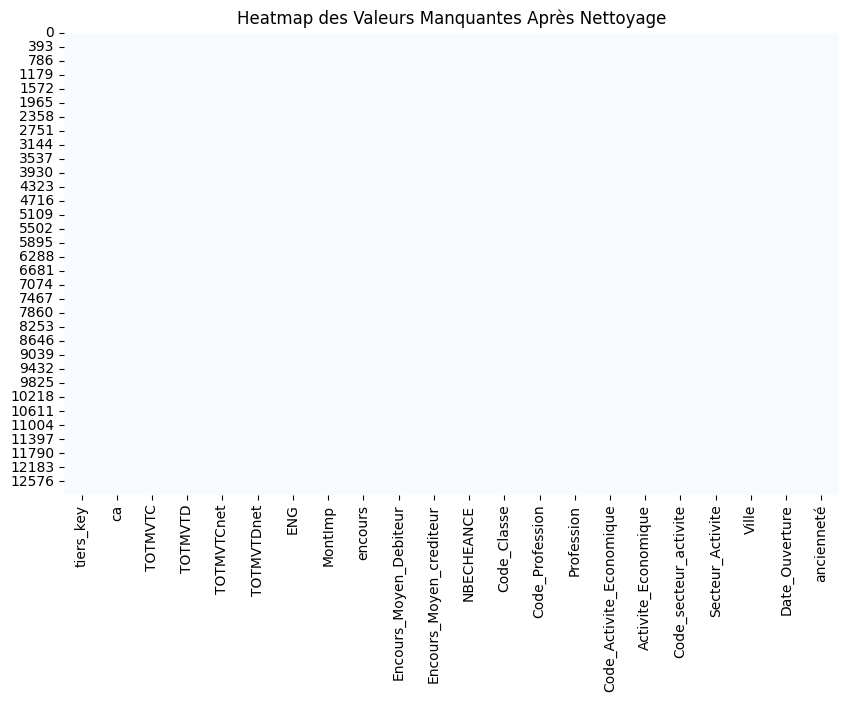

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualiser les valeurs manquantes après le nettoyage
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="Blues")
plt.title('Heatmap des Valeurs Manquantes Après Nettoyage')
plt.show()


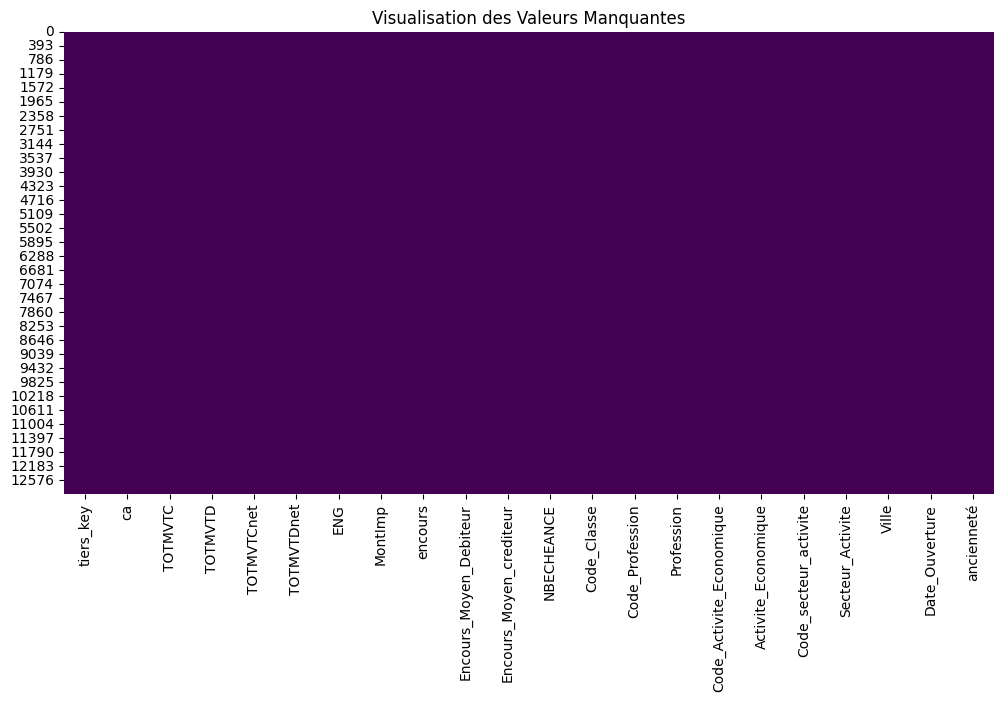

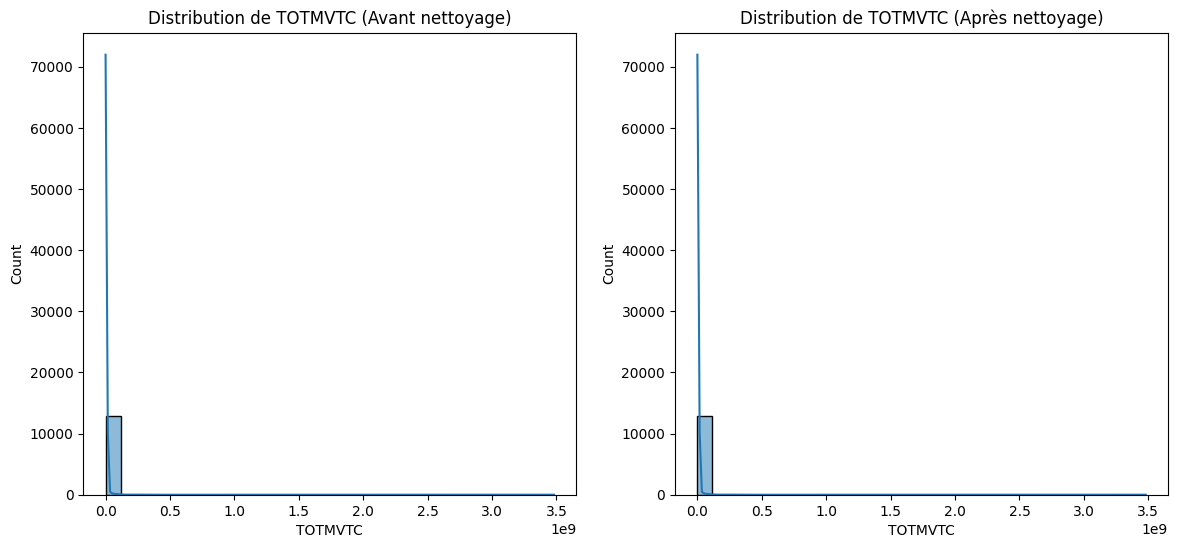

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisation des valeurs manquantes
def plot_missing_values(df):
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Visualisation des Valeurs Manquantes')
    plt.show()

# Distribution des variables avant et après nettoyage
def plot_distribution(df, column):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Distribution de {column} (Avant nettoyage)')

    # Appliquer le nettoyage ici...

    plt.subplot(1, 2, 2)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Distribution de {column} (Après nettoyage)')
    plt.show()

# Exemple d'utilisation
plot_missing_values(df)
plot_distribution(df, 'TOTMVTC')


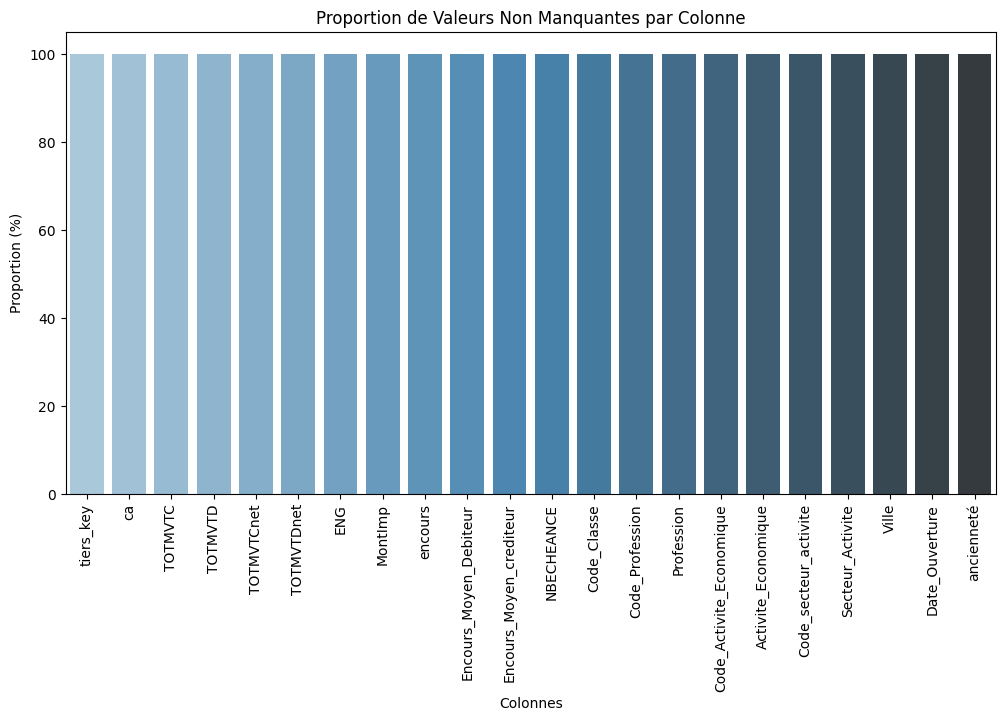

In [15]:
def plot_non_missing_proportion(df):
    non_missing_counts = df.notnull().sum()
    proportions = non_missing_counts / len(df) * 100

    plt.figure(figsize=(12, 6))
    sns.barplot(x=proportions.index, y=proportions.values, palette='Blues_d')
    plt.title('Proportion de Valeurs Non Manquantes par Colonne')
    plt.xticks(rotation=90)
    plt.xlabel('Colonnes')
    plt.ylabel('Proportion (%)')
    plt.show()

# Afficher la proportion de valeurs non manquantes
plot_non_missing_proportion(df)
